### Bio Clustering (Word2Vec and Kmeans Clustering)

In [183]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

from  sklearn.cluster import KMeans
import glob
import gensim 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading file and creating dataframe

In [184]:
file = os.listdir("_data/unlabled/")
file

['bio_1501672304.9134998.txt',
 'bio_1501694930.6841238.txt',
 'bio_1501598612.022413.txt',
 'bio_1501693740.803672.txt']

In [185]:
all_data = []
for i in file:
    with open("_data/unlabled/{}".format(i)) as f:
        temp_data = f.read().split('\n')
    all_data.extend(temp_data)

In [186]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [187]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()
df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.count()

bio    44440
dtype: int64

In [188]:
df.describe()

,bio
count,44440
unique,44440
top,Attempting reverse engineer whatever I spatial...
freq,1


In [189]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [190]:
df['word_freq'].mean()

10.326597659765977

### Word2Vec Feature Extraction

In [191]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [192]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [193]:
sentences[909]

['artist', 'voice', 'voiceless']

In [194]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 459,007 tokens


**Word2Vec model**



In [13]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [195]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 100
)

print("Train Time:", time()-t0)

Train Time: 234.22471070289612


In [196]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [197]:
bio_vec.most_similar_cosmul("machine")

[('learning', 0.8518628478050232),
 ('algorithms', 0.7328687906265259),
 ('tensorflow', 0.7207638025283813),
 ('nlproc', 0.7181356549263),
 ('simulation', 0.7090402841567993),
 ('recursecenter', 0.7041191458702087),
 ('udacity', 0.7024855613708496),
 ('emsp', 0.7021226286888123),
 ('neural', 0.6941787600517273),
 ('nlp', 0.6938244700431824)]

In [198]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 13684


### Visualization and word-D-reduction

In [199]:
t1 = time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

MemoryError: 

In [20]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

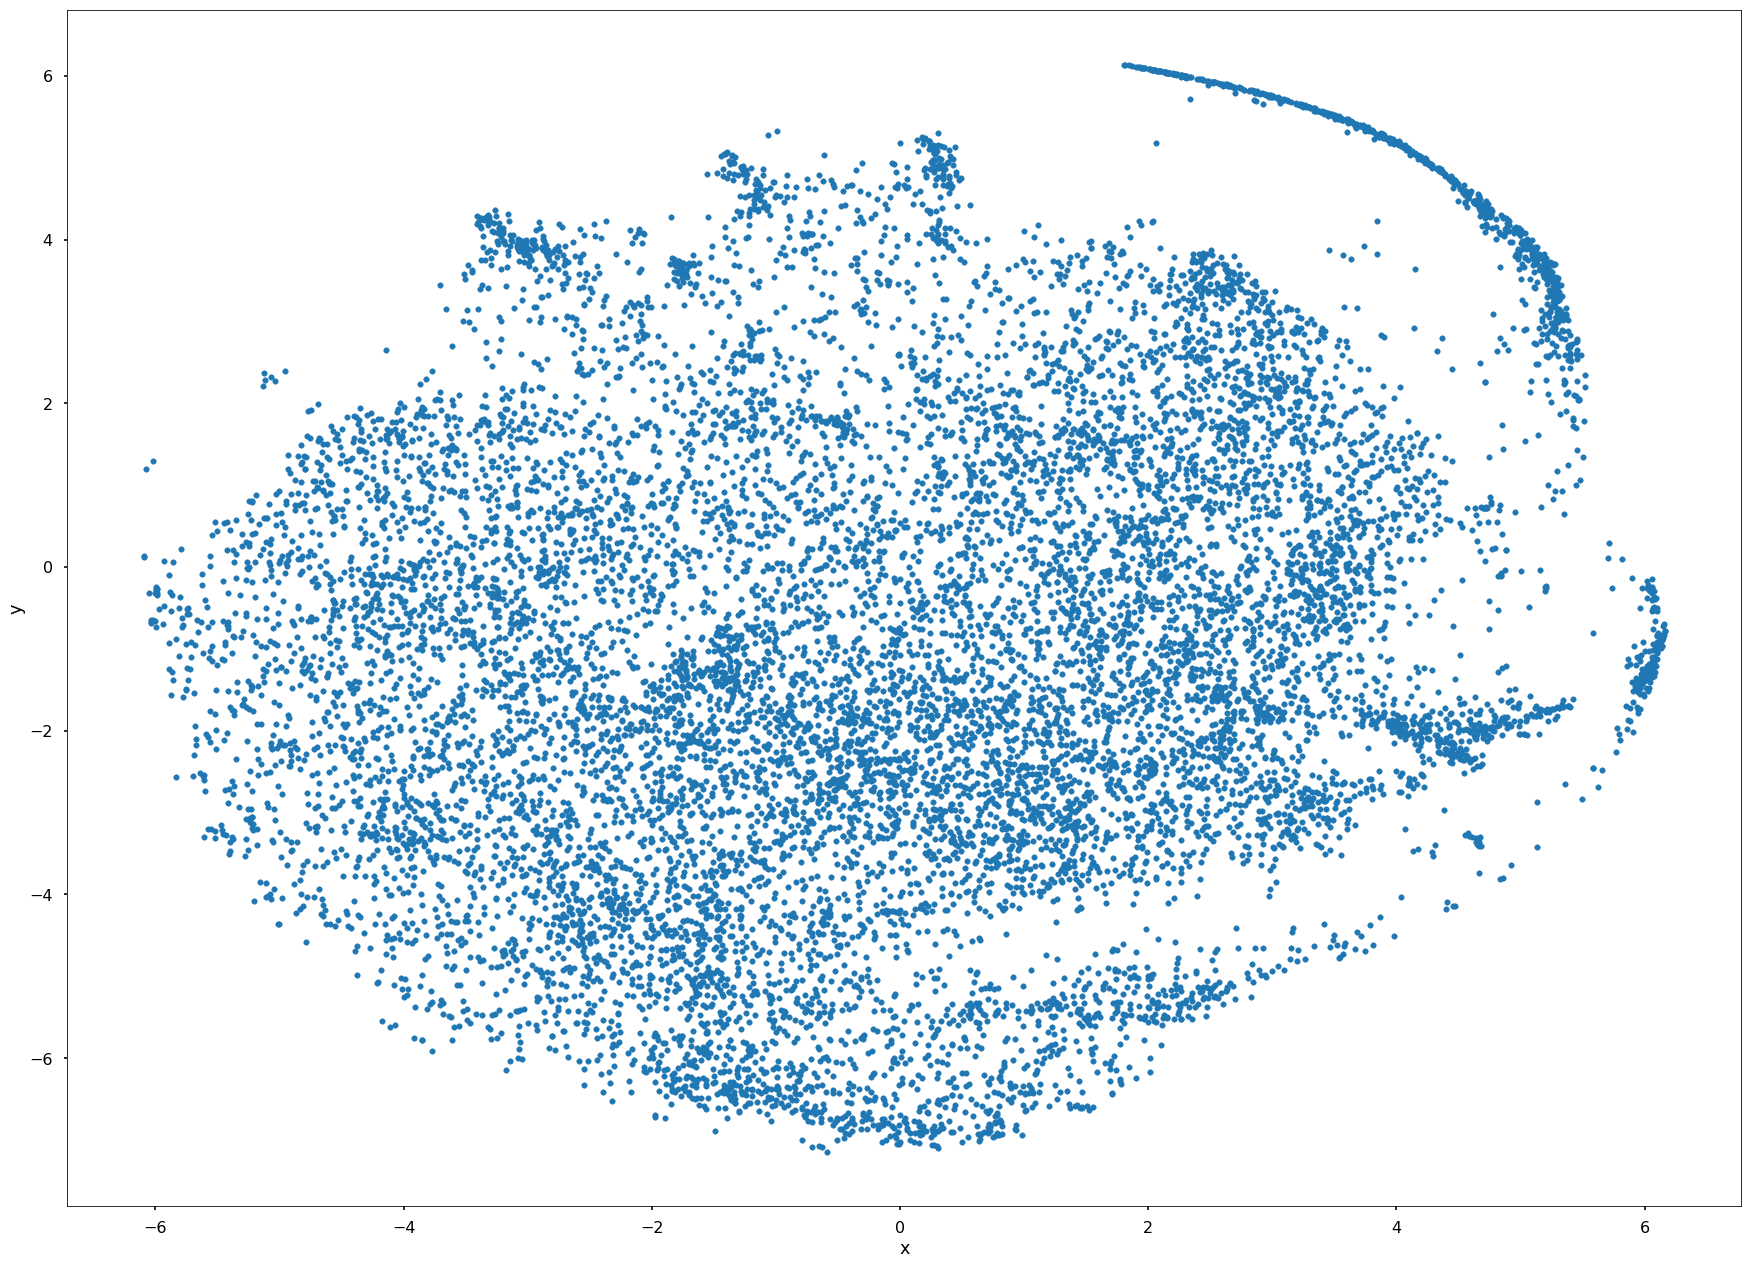

In [21]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [22]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

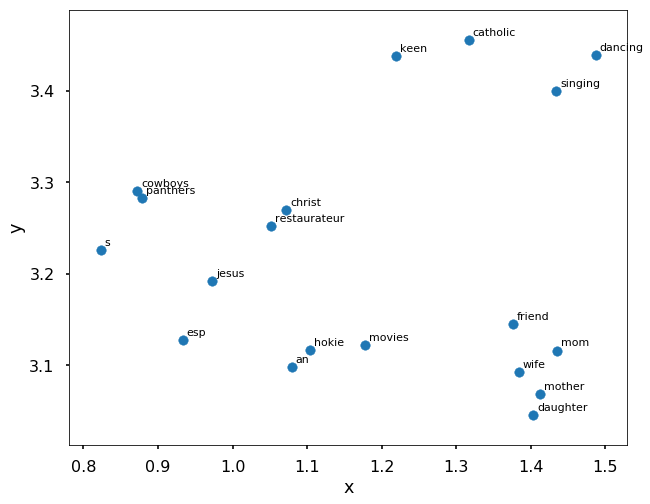

In [31]:
plot_region(x_bounds=(0.8, 1.5), y_bounds=(3, 3.5))

plt.show()

In [49]:
np.save("_data/trained/reduced_dim", all_word_vectors_matrix_2d)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=150, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 1.092s


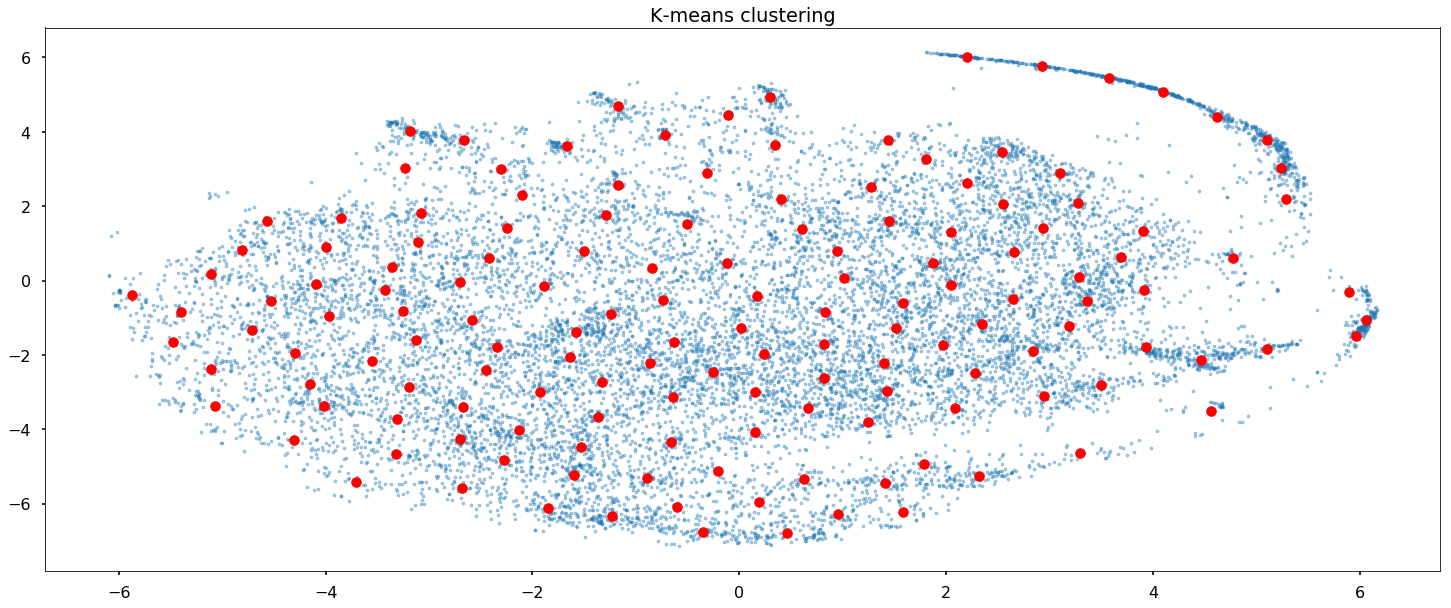

In [93]:
w2v_km = kmeans(all_word_vectors_matrix_2d, 150)

In [94]:
w2v_cluster = {i: points.loc[np.where(w2v_km.labels_ == i)[0]].word for i in range(w2v_km.n_clusters)}

In [95]:
w2v_cluster[0]

43             artificial
74                 hadoop
316              newsweek
348               electro
528         healthyeating
1051               cordon
1070               ubuntu
1093             founding
1206             partners
1908               quando
1958                  mcd
2130        timesinternet
2416             followme
2422               cision
2940               tester
2943              worship
3103                their
3993                 road
4118              defense
4281              penguin
4407               dabble
4445                  sho
4455     studentsforrubio
4735                 face
4845              meaning
4852             branding
4919               direct
4977            paintings
5008                  fsu
5146              swimmer
               ...       
10626            national
10635          disposable
10680                agro
10846         battlefield
10888             myanmar
10905            republic
10928              enrich
10935       

### Sentence Embedding and Clustering

In [201]:
def preprocess_text(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|
                [a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
                (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    tokens = word_tokenize(raw.lower())
    return tokens

In [202]:
def embed_sentences(s):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    for t in sample_text_tokens:
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, bio_vec[t]])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [ ]:
sentence_vectors = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    sentence_vectors = np.vstack([sentence_vectors, embed_sentences(row['bio'])])

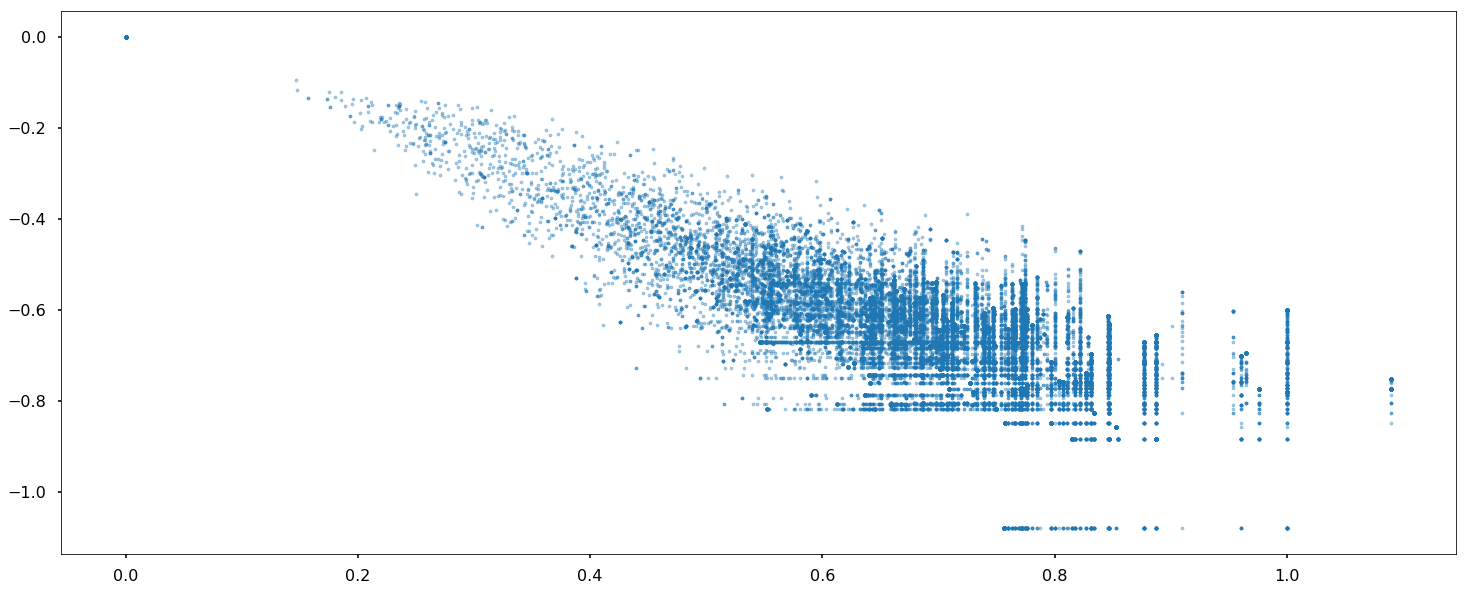

In [38]:
plt.figure(figsize=(25, 10))
plt.scatter([i[0] for i in sentence_vectors], [i[1] for i in sentence_vectors], s=10, alpha=0.4)
plt.show()

In [39]:
def kmeans(data, clus):
    km = KMeans(n_clusters=clus, init='k-means++', max_iter=1000, n_init=1,
                    verbose=False)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(data)
    print("done in %0.3fs" % (time() - t0))

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1


    plt.figure(figsize=(25, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.4)

    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=90, linewidths=1,
                color='r')
    plt.title('K-means clustering')
    plt.show()
    return km

### Word2Vec + TfIDF

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [161]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

TfX = vectorizer.fit_transform(df['bio'])

In [162]:
feature_names = vectorizer.get_feature_names()
def get_tfidf_weight(doc):
    feature_index =TfX[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [TfX[doc, x] for x in feature_index])
    result = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        result[w] = s
    return result

In [163]:
get_tfidf_weight(100)

{'culture': 0.63859712849633621,
 'tech': 0.5483881130490118,
 'views': 0.53987423067116092}

In [164]:
def embed_sentences_tfidf_weight(s, doc):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 1
    for t in sample_text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in google_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, np.add(vector_weight, bio_vec[t])])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [165]:
sentence_vectors_tf = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf = np.vstack([sentence_vectors_tf, embed_sentences_tfidf_weight(row['bio'], i)])
    i+=1

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.303s


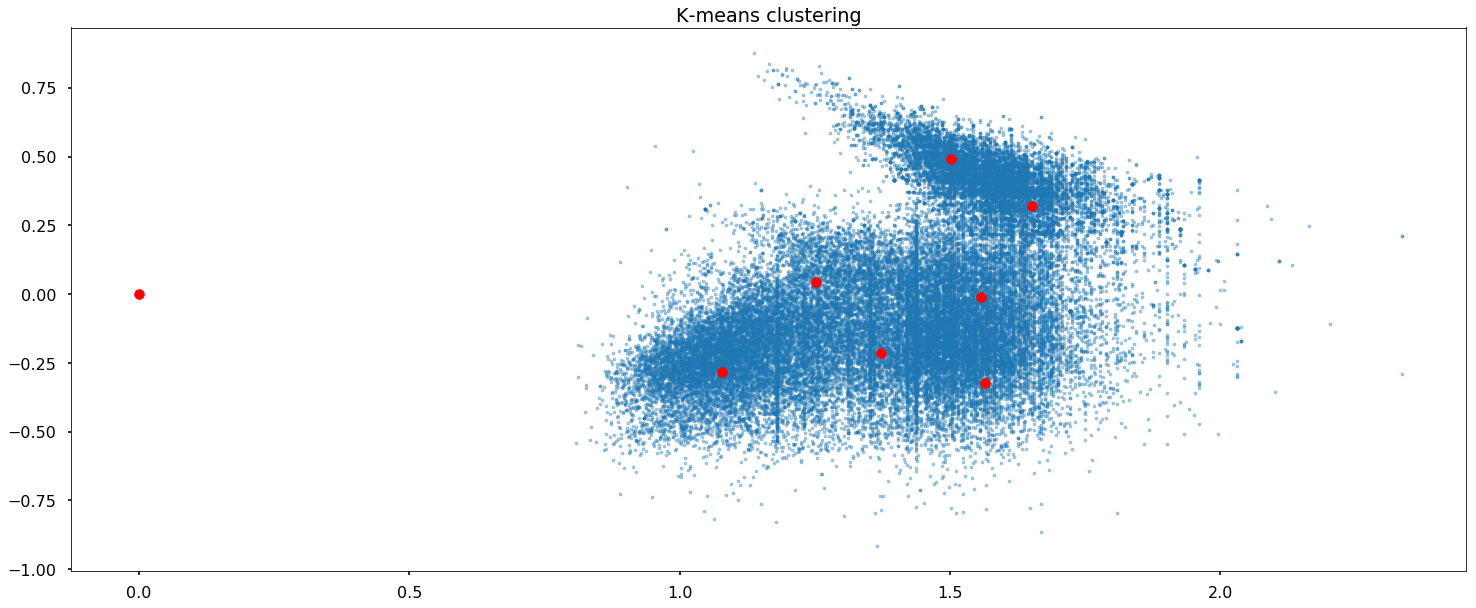

In [166]:
kmean_tfidf_w2v = kmeans(sentence_vectors_tf, 8)

In [167]:
clusters_tfidf = {i: df['bio'][np.where(kmean_tfidf_w2v.labels_ == i)[0]] for i in range(kmean_tfidf_w2v.n_clusters)}

In [168]:
clusters_tfidf[1]

0        The book PanamaPapers b obermayer f obermaier ...
6                           Flipkart research lab Bay Area
10                                   Infrastructure airbnb
14                                  Exec Chairman Flipkart
16                                                Building
39               SonOfAbish Comedian Instagram AbishMathew
44                           The voice people Sorry people
45                                      planet outer space
47                                  I see political people
53                                     Luxury Bike Rentals
63                                Signals help read future
68                                        Chal bhaag saala
81                                      Been Done Then AND
89                                                     Ola
91                                               Raconteur
98                                        I writing fast I
120                                         What need kn

### Word2Vec + ResultantVec

In [152]:
def embed_sentences_resultant(s):
    text_tokens = preprocess_text(s)
    word_vectors = np.zeros(300,)
    v_words = 0
    for t in text_tokens:
        if t in bio_vec.wv.vocab.keys():
            v_words+=1
            word_vectors = np.add(word_vectors, bio_vec[t])
    if len(word_vectors):
        return np.divide(word_vectors, v_words)
#         return word_vectors
    else:
        return [0, 0]

In [153]:
embed_sentences_resultant("hello").max()

0.50390625

In [154]:
sentence_vectors_resultant = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    s_vec = embed_sentences_resultant(row['bio'])
    sentence_vectors_resultant = np.vstack([sentence_vectors_resultant, [s_vec.max(), s_vec.min()] ])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [155]:
sentence_vectors_resultant = pd.DataFrame(sentence_vectors_resultant)
sentence_vectors_resultant.fillna(0, inplace=True)
sentence_vectors_resultant = np.array(sentence_vectors_resultant)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.494s


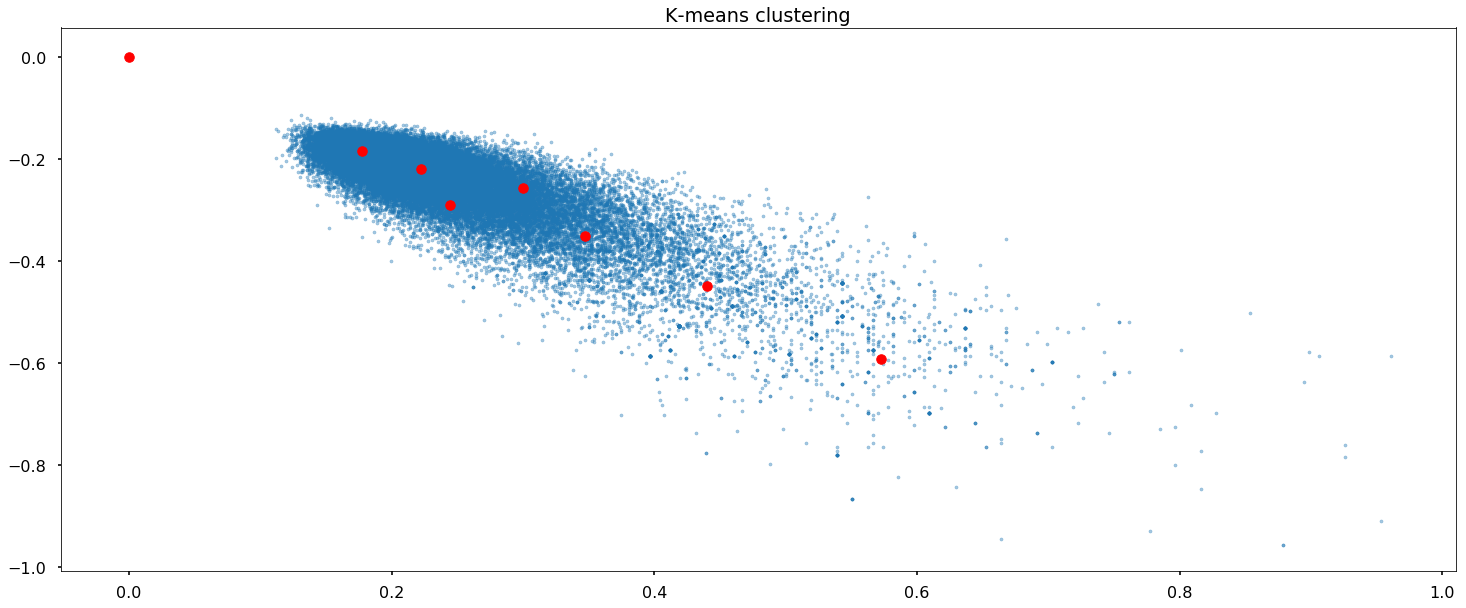

In [156]:
kmean_result = kmeans(sentence_vectors_resultant, 8)

In [157]:
clusters_res = {i: df['bio'][np.where(kmean_result.labels_ == i)[0]] for i in range(kmean_result.n_clusters)}

In [158]:
clusters_res[0]

7        Stay connected Flipkart Seller Hub account ded...
11       We tweet technology Technology use technology ...
12       Official account news stories culture happenin...
19       A wannabe perfectionist erroneous reality Pass...
23                        You come king best miss thuglife
27              Current serving CEO Dr Ajay Bhushan Pandey
29       CEO Myntra Jabong Ex McKinsey Working intersec...
30       Poet Journalist Editor Parliamentarian Founder...
37       News lifestyle stories matter millennial Hop k...
41       Deputy Editor Huffington Post India Feminist M...
42       Editor Chief FiveThirtyEight Author The Signal...
44                           The voice people Sorry people
47                                  I see political people
49       Comedian talk show host ice road trucker My tw...
56       Professor HarvardHBS Author CompetingvsLuck Co...
61       Welcome official twitter page Office His Holin...
62       Breaking news scoops depth coverage startups e.

#### Saving Clusters Data

In [169]:
def save_clusters(cluster_t, cluster_name):
    if not os.path.exists("_data/{}".format(cluster_name)):
        os.makedirs("_data/{}".format(cluster_name))
    path = "_data/{}/".format(cluster_name)
    for i,c in enumerate(cluster_t):
        with open(path+str(i), 'a') as f:
            for t in cluster_t[c]:
                f.write(str(t))
                f.write('\n')
            f.close()
    print("Saved {}".format(cluster_name))

In [170]:
save_clusters(clusters_res, "cluster_res")

Saved cluster_res


In [171]:
save_clusters(clusters_tfidf, "cluster_tfidf")

Saved cluster_tfidf


### Semantic Clustering!

In [105]:
def semantic_score(s1, s2):
    s1p = [i for i in preprocess_text(s1) if i in bio_vec.wv.vocab]
    s2p = [i for i in preprocess_text(s2) if i in bio_vec.wv.vocab]
    if len(s1p) and len(s2p):
        return google_vec.n_similarity(s1p, s2p)
    else:
        return 0.0

In [161]:
from collections import Counter